Loading data from Timekeeping.xlsx and Payroll.xlsx...
Preprocessing complete. Timekeeping records: 25052, Payroll records: 138
Analyzing meal break compliance...
Compliance analysis complete. Found 3316 violations out of 25052 shifts.
Imputing 4654 missing pay rates...
Financial impact calculated: $232401.02 total penalties, $19.49 avg per violation
Imputing 4654 missing pay rates...
Financial impact calculated: $232401.02 total penalties, $19.49 avg per violation
Imputing 4654 missing pay rates...
Financial impact calculated: $232401.02 total penalties, $19.49 avg per violation
Imputing 4654 missing pay rates...
Financial impact calculated: $232401.02 total penalties, $19.49 avg per violation
Report saved to analysis_results/compliance_report.md
Analysis complete!

--- MEAL BREAK COMPLIANCE ANALYSIS SUMMARY ---
Total Shifts: 25052
Compliant Shifts: 21736 (86.76%)
Violation Shifts: 3316 (13.24%)
Financial Impact: $232401.02

--- KEY RECOMMENDATIONS ---

Overall Strategy:
1. Implement 

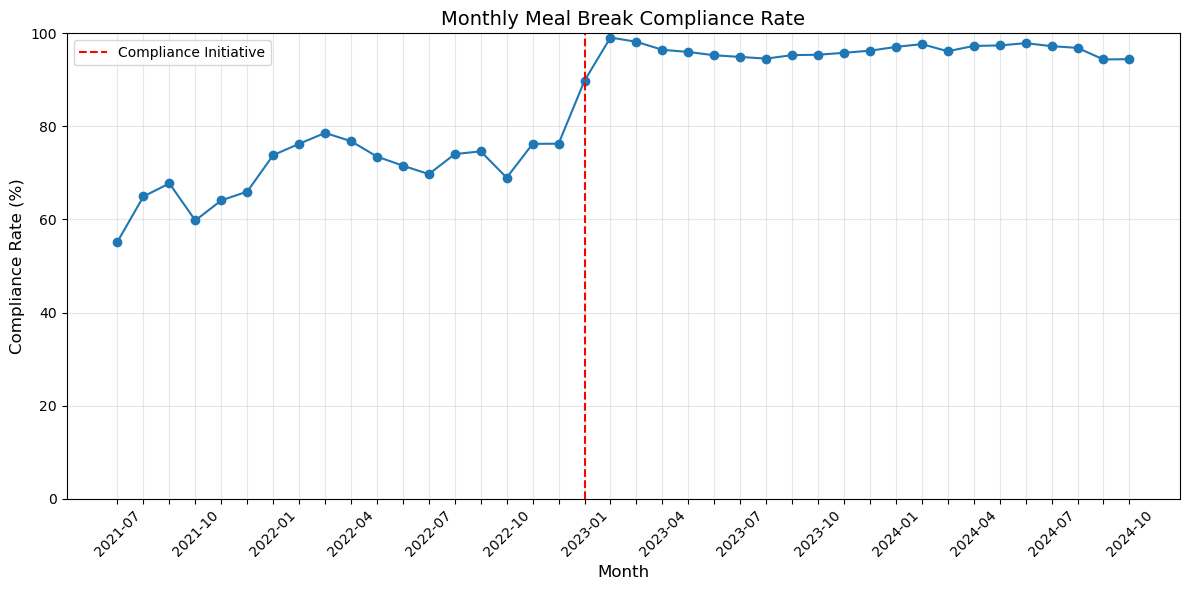

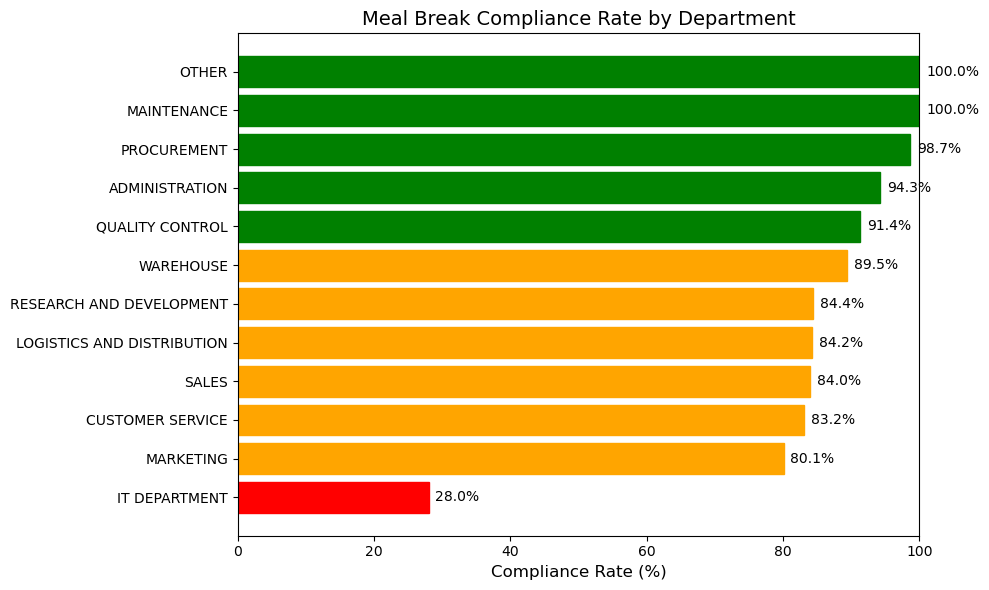

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

class MealBreakComplianceAnalyzer:
    """
    A class to analyze meal break compliance according to California's Section 512(a).
    This analyzes Company XYZ's adherence to meal break laws and provides recommendations.
    """
    
    def __init__(self, timekeeping_file, payroll_file):
        """
        Initialize the analyzer with the timekeeping and payroll data files.
        
        Args:
            timekeeping_file (str): Path to the timekeeping Excel file
            payroll_file (str): Path to the payroll Excel file
        """
        print(f"Loading data from {timekeeping_file} and {payroll_file}...")
        self.timekeeping_df = pd.read_excel(timekeeping_file)
        self.payroll_df = pd.read_excel(payroll_file)
        
        # Pre-process data
        self._preprocess_data()
        
    def _preprocess_data(self):
        """Preprocess the timekeeping and payroll data."""
        # Convert datetime columns to datetime type if they aren't already
        datetime_cols = ['punchin1', 'punchout1', 'punchin2', 'punchout2', 'punchin3', 'punchout3']
        for col in datetime_cols:
            if col in self.timekeeping_df.columns:
                self.timekeeping_df[col] = pd.to_datetime(self.timekeeping_df[col], errors='coerce')
        
        # Convert date column to datetime if it's not already
        if 'date' in self.timekeeping_df.columns:
            self.timekeeping_df['date'] = pd.to_datetime(self.timekeeping_df['date'], errors='coerce')
        
        # Convert employee_id to string to ensure consistent joining
        self.timekeeping_df['employee_id'] = self.timekeeping_df['employee_id'].astype(str)
        self.payroll_df['employee_id'] = self.payroll_df['employee_id'].astype(str)
        
        # Create additional date features for analysis
        self.timekeeping_df['year_month'] = self.timekeeping_df['date'].dt.strftime('%Y-%m')
        self.timekeeping_df['day_of_week'] = self.timekeeping_df['date'].dt.dayofweek
        self.timekeeping_df['day_name'] = self.timekeeping_df['date'].dt.day_name()
        
        # Handle any missing pay rates in payroll data
        self.payroll_df['pay_rate'] = pd.to_numeric(self.payroll_df['pay_rate'], errors='coerce')
        
        print(f"Preprocessing complete. Timekeeping records: {len(self.timekeeping_df)}, Payroll records: {len(self.payroll_df)}")
        
    def _calculate_hours_between(self, start_time, end_time):
        """
        Calculate hours between two datetime values.
        
        Args:
            start_time: Start datetime
            end_time: End datetime
            
        Returns:
            float: Hours between start and end (0 if either is None)
        """
        if pd.isna(start_time) or pd.isna(end_time):
            return 0
        
        return (end_time - start_time).total_seconds() / 3600
        
    def analyze_compliance(self):
        """
        Analyze meal break compliance for each shift.
        
        Returns:
            DataFrame: Timekeeping data with compliance analysis columns added
        """
        print("Analyzing meal break compliance...")
        # Create a copy of the dataframe to avoid modifying the original
        df = self.timekeeping_df.copy()
        
        # Calculate work periods and meal breaks
        df['work_period1_hours'] = df.apply(lambda row: self._calculate_hours_between(row['punchin1'], row['punchout1']), axis=1)
        df['work_period2_hours'] = df.apply(lambda row: self._calculate_hours_between(row['punchin2'], row['punchout2']), axis=1)
        df['meal_break1_hours'] = df.apply(lambda row: self._calculate_hours_between(row['punchout1'], row['punchin2']), axis=1)
        
        # Handle optional third work period and second meal break
        df['work_period3_hours'] = df.apply(lambda row: self._calculate_hours_between(row['punchin3'], row['punchout3']), axis=1)
        df['meal_break2_hours'] = df.apply(lambda row: self._calculate_hours_between(row['punchout2'], row['punchin3']), axis=1)
        
        # Calculate total work hours for each shift
        df['total_work_hours'] = df['work_period1_hours'] + df['work_period2_hours'] + df['work_period3_hours']
        
        # Analyze first meal break compliance (5-hour rule)
        # Employees working more than 5 hours must receive a 30-minute meal break, 
        # unless the workday is 6 hours or less (waiver possible by mutual consent).
        df['first_meal_required'] = df['total_work_hours'] > 5
        df['first_meal_taken'] = df['meal_break1_hours'] >= 0.5
        df['first_meal_compliant'] = ~(
            (df['total_work_hours'] > 5) & 
            (df['meal_break1_hours'] < 0.5) & 
            (df['total_work_hours'] > 6)
        )
        
        # Analyze second meal break compliance (10-hour rule)
        # Employees working more than 10 hours must receive a second 30-minute meal break, 
        # with a waiver option if the total hours do not exceed 12 (provided the first break wasn't waived).
        df['second_meal_required'] = df['total_work_hours'] > 10
        df['second_meal_taken'] = df['meal_break2_hours'] >= 0.5
        df['second_meal_compliant'] = ~(
            (df['total_work_hours'] > 10) & 
            (df['meal_break2_hours'] < 0.5) & 
            ((df['total_work_hours'] > 12) | (df['meal_break1_hours'] < 0.5))
        )
        
        # Determine overall compliance
        df['is_compliant'] = df['first_meal_compliant'] & df['second_meal_compliant']
        
        # Set violation reason if not compliant
        df['violation_reason'] = ''
        df.loc[~df['first_meal_compliant'], 'violation_reason'] = 'Missing first meal break'
        df.loc[~df['second_meal_compliant'], 'violation_reason'] = 'Missing second meal break'
        
        self.analyzed_df = df
        print(f"Compliance analysis complete. Found {(~df['is_compliant']).sum()} violations out of {len(df)} shifts.")
        return df
    
    def calculate_financial_impact(self, impute_missing=True):
        """
        Calculate the financial impact of meal break violations.
        
        Args:
            impute_missing (bool): Whether to impute missing pay rates
            
        Returns:
            tuple: (total_penalty, average_penalty_per_violation, violations_count, missing_rate_count)
        """
        if not hasattr(self, 'analyzed_df'):
            self.analyze_compliance()
            
        # Merge with payroll data to get pay rates
        merged_df = self.analyzed_df.merge(
            self.payroll_df[['employee_id', 'pay_rate']], 
            on='employee_id', 
            how='left'
        )
        
        # Handle missing pay rates if requested
        missing_rate_count = merged_df['pay_rate'].isna().sum()
        
        if impute_missing and missing_rate_count > 0:
            print(f"Imputing {missing_rate_count} missing pay rates...")
            # Get average pay rate by department
            dept_avg_rates = merged_df.groupby('department')['pay_rate'].mean()
            
            # Fill missing values with department average, or overall average if department has no rates
            overall_avg = merged_df['pay_rate'].mean()
            
            for dept in merged_df['department'].unique():
                dept_mask = (merged_df['department'] == dept) & (merged_df['pay_rate'].isna())
                if dept in dept_avg_rates and not pd.isna(dept_avg_rates[dept]):
                    merged_df.loc[dept_mask, 'pay_rate'] = dept_avg_rates[dept]
                else:
                    merged_df.loc[dept_mask, 'pay_rate'] = overall_avg
            
            # Any remaining NaN values get the overall average
            merged_df['pay_rate'].fillna(overall_avg, inplace=True)
        
        # Calculate penalties (one hour of pay per violation)
        violations = merged_df[~merged_df['is_compliant']]
        total_penalty = violations['pay_rate'].sum()
        violations_count = len(violations)
        avg_penalty = total_penalty / violations_count if violations_count > 0 else 0
        
        print(f"Financial impact calculated: ${total_penalty:.2f} total penalties, ${avg_penalty:.2f} avg per violation")
        return total_penalty, avg_penalty, violations_count, missing_rate_count
    
    def analyze_by_department(self):
        """
        Analyze compliance rates by department.
        
        Returns:
            DataFrame: Compliance statistics by department
        """
        if not hasattr(self, 'analyzed_df'):
            self.analyze_compliance()
            
        dept_stats = self.analyzed_df.groupby('department').agg(
            total_shifts=('employee_id', 'count'),
            violations=('is_compliant', lambda x: (~x).sum()),
            avg_shift_length=('total_work_hours', 'mean')
        ).reset_index()
        
        dept_stats['compliance_rate'] = (dept_stats['total_shifts'] - dept_stats['violations']) / dept_stats['total_shifts']
        dept_stats = dept_stats.sort_values('compliance_rate')
        
        return dept_stats
    
    def analyze_by_supervisor(self, min_shifts=100):
        """
        Analyze compliance rates by supervisor.
        
        Args:
            min_shifts (int): Minimum number of shifts for a supervisor to be included
            
        Returns:
            DataFrame: Compliance statistics by supervisor
        """
        if not hasattr(self, 'analyzed_df'):
            self.analyze_compliance()
            
        # Group by supervisor
        sup_counts = self.analyzed_df.groupby('Supervisor').size()
        valid_supervisors = sup_counts[sup_counts >= min_shifts].index
        
        filtered_df = self.analyzed_df[self.analyzed_df['Supervisor'].isin(valid_supervisors)]
        
        sup_stats = filtered_df.groupby('Supervisor').agg(
            total_shifts=('employee_id', 'count'),
            violations=('is_compliant', lambda x: (~x).sum()),
            avg_shift_length=('total_work_hours', 'mean')
        ).reset_index()
        
        sup_stats['compliance_rate'] = (sup_stats['total_shifts'] - sup_stats['violations']) / sup_stats['total_shifts']
        sup_stats = sup_stats.sort_values('compliance_rate')
        
        return sup_stats
    
    def analyze_by_employee(self, min_shifts=30):
        """
        Analyze compliance rates by employee.
        
        Args:
            min_shifts (int): Minimum number of shifts for an employee to be included
            
        Returns:
            DataFrame: Compliance statistics by employee
        """
        if not hasattr(self, 'analyzed_df'):
            self.analyze_compliance()
            
        # Group by employee
        emp_counts = self.analyzed_df.groupby('employee_id').size()
        valid_employees = emp_counts[emp_counts >= min_shifts].index
        
        filtered_df = self.analyzed_df[self.analyzed_df['employee_id'].isin(valid_employees)]
        
        # Get department and supervisor for each employee (using mode)
        emp_dept = filtered_df.groupby('employee_id')['department'].agg(lambda x: x.mode()[0]).reset_index()
        emp_sup = filtered_df.groupby('employee_id')['Supervisor'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else "Unknown").reset_index()
        
        emp_stats = filtered_df.groupby('employee_id').agg(
            total_shifts=('date', 'count'),
            violations=('is_compliant', lambda x: (~x).sum()),
            avg_shift_length=('total_work_hours', 'mean')
        ).reset_index()
        
        # Merge with department and supervisor info
        emp_stats = emp_stats.merge(emp_dept, on='employee_id', how='left')
        emp_stats = emp_stats.merge(emp_sup, on='employee_id', how='left')
        
        emp_stats['violation_rate'] = emp_stats['violations'] / emp_stats['total_shifts']
        emp_stats = emp_stats.sort_values('violations', ascending=False)
        
        return emp_stats
    
    def analyze_monthly_trends(self):
        """
        Analyze compliance trends by month.
        
        Returns:
            DataFrame: Monthly compliance statistics
        """
        if not hasattr(self, 'analyzed_df'):
            self.analyze_compliance()
            
        monthly_stats = self.analyzed_df.groupby('year_month').agg(
            total_shifts=('employee_id', 'count'),
            violations=('is_compliant', lambda x: (~x).sum())
        ).reset_index()
        
        monthly_stats['compliance_rate'] = (monthly_stats['total_shifts'] - monthly_stats['violations']) / monthly_stats['total_shifts']
        monthly_stats = monthly_stats.sort_values('year_month')
        
        return monthly_stats
    
    def plot_monthly_trends(self, save_path=None):
        """
        Plot compliance trends over time.
        
        Args:
            save_path (str, optional): Path to save the figure
            
        Returns:
            matplotlib.figure: Figure object containing the plot
        """
        monthly_data = self.analyze_monthly_trends()
        
        plt.figure(figsize=(12, 6))
        plt.plot(monthly_data.index, monthly_data['compliance_rate'] * 100, marker='o', linestyle='-')
        
        # Add reference line for implementation of improvement initiative (assumed to be Jan 2023)
        improvement_date = '2023-01'
        if improvement_date in monthly_data['year_month'].values:
            idx = monthly_data[monthly_data['year_month'] == improvement_date].index[0]
            plt.axvline(x=idx, color='r', linestyle='--', label='Compliance Initiative')
            plt.legend()
        
        plt.title('Monthly Meal Break Compliance Rate', fontsize=14)
        plt.xlabel('Month', fontsize=12)
        plt.ylabel('Compliance Rate (%)', fontsize=12)
        plt.ylim(0, 100)
        plt.grid(True, alpha=0.3)
        
        # Rotate x-axis labels for better readability
        plt.xticks(range(len(monthly_data)), monthly_data['year_month'], rotation=45)
        
        # Show every nth label to avoid overcrowding
        n = 3
        for i, label in enumerate(plt.gca().xaxis.get_ticklabels()):
            if i % n != 0:
                label.set_visible(False)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
            
        return plt.gcf()
    
    def plot_department_compliance(self, save_path=None):
        """
        Plot compliance rates by department.
        
        Args:
            save_path (str, optional): Path to save the figure
            
        Returns:
            matplotlib.figure: Figure object containing the plot
        """
        dept_data = self.analyze_by_department()
        
        # Sort by compliance rate for better visualization
        dept_data = dept_data.sort_values('compliance_rate')
        
        plt.figure(figsize=(10, 6))
        bars = plt.barh(dept_data['department'], dept_data['compliance_rate'] * 100)
        
        # Color bars based on compliance rate (red for poor, yellow for medium, green for good)
        colors = ['red' if x < 0.8 else 'orange' if x < 0.9 else 'green' for x in dept_data['compliance_rate']]
        for bar, color in zip(bars, colors):
            bar.set_color(color)
        
        plt.title('Meal Break Compliance Rate by Department', fontsize=14)
        plt.xlabel('Compliance Rate (%)', fontsize=12)
        plt.xlim(0, 100)
        
        # Add value labels to the bars
        for i, v in enumerate(dept_data['compliance_rate']):
            plt.text(v * 100 + 1, i, f"{v*100:.1f}%", va='center')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
            
        return plt.gcf()
    
    def generate_recommendations(self):
        """
        Generate recommendations based on the analysis.
        
        Returns:
            dict: Recommendations organized by category
        """
        if not hasattr(self, 'analyzed_df'):
            self.analyze_compliance()
            
        # Get key statistics
        dept_stats = self.analyze_by_department()
        sup_stats = self.analyze_by_supervisor()
        emp_stats = self.analyze_by_employee()
        monthly_stats = self.analyze_monthly_trends()
        total_penalty, avg_penalty, violations_count, _ = self.calculate_financial_impact()
        
        # Identify problem areas
        problem_depts = dept_stats[dept_stats['compliance_rate'] < 0.85]
        problem_sups = sup_stats[sup_stats['compliance_rate'] < 0.80]
        problem_emps = emp_stats[emp_stats['violation_rate'] > 0.30]
        
        # Check if there was improvement after a certain date (Jan 2023)
        before_initiative = monthly_stats[monthly_stats['year_month'] < '2023-01']
        after_initiative = monthly_stats[monthly_stats['year_month'] >= '2023-01']
        
        avg_compliance_before = before_initiative['compliance_rate'].mean() if not before_initiative.empty else 0
        avg_compliance_after = after_initiative['compliance_rate'].mean() if not after_initiative.empty else 0
        improvement = avg_compliance_after - avg_compliance_before
        
        # Generate recommendations
        recommendations = {
            'overall_strategy': [
                "Implement a standardized meal break policy across all departments",
                "Create an automated notification system to alert employees and supervisors before meal break deadlines",
                "Establish a clear escalation process for managing meal break exceptions"
            ],
            'department_specific': [],
            'supervisor_training': [],
            'employee_coaching': [],
            'financial_impact': [],
            'monitoring': [
                "Continue tracking meal break compliance metrics on a monthly basis",
                "Create a dashboard for supervisors to monitor their team's compliance in real-time",
                "Conduct quarterly reviews of compliance patterns and adjust strategies as needed"
            ]
        }
        
        # Department-specific recommendations
        for _, dept in problem_depts.iterrows():
            recommendations['department_specific'].append(
                f"Focus on {dept['department']} department with {dept['compliance_rate']*100:.1f}% compliance rate - "
                f"Implement department-specific meal break scheduling"
            )
        
        # Supervisor training recommendations
        for _, sup in problem_sups.iterrows():
            recommendations['supervisor_training'].append(
                f"Provide additional training to supervisor {sup['Supervisor']} (compliance rate: {sup['compliance_rate']*100:.1f}%)"
            )
        
        # Employee coaching recommendations
        for _, emp in problem_emps.head(5).iterrows():
            recommendations['employee_coaching'].append(
                f"Coach employee {emp['employee_id']} who has {emp['violations']} violations out of {emp['total_shifts']} shifts "
                f"({emp['violation_rate']*100:.1f}% violation rate)"
            )
        
        # Financial impact recommendations
        recommendations['financial_impact'] = [
            f"Total financial exposure: ${total_penalty:.2f} in potential penalties",
            f"Average penalty per violation: ${avg_penalty:.2f}",
            "Create a compliance incentive program to reduce financial exposure",
            "Allocate additional resources to departments with highest financial impact"
        ]
        
        # Assessment of past efforts
        if improvement > 0.1:  # Significant improvement
            recommendations['past_efforts_assessment'] = [
                f"Past compliance efforts appear successful with improvement from {avg_compliance_before*100:.1f}% to {avg_compliance_after*100:.1f}%",
                "Continue and expand the current compliance program",
                "Document successful strategies for company-wide implementation"
            ]
        else:
            recommendations['past_efforts_assessment'] = [
                f"Limited improvement observed ({improvement*100:.1f}% change in compliance rate)",
                "Re-evaluate current compliance strategies and identify barriers",
                "Consider more aggressive intervention in problematic areas"
            ]
        
        return recommendations

def create_compliance_report(analyzer, output_file=None):
    """
    Create a formatted compliance report based on analysis results.
    
    Args:
        analyzer (MealBreakComplianceAnalyzer): Initialized and run analyzer
        output_file (str, optional): Path to save the report
        
    Returns:
        str: Formatted report text
    """
    # Run analysis if it hasn't been run yet
    if not hasattr(analyzer, 'analyzed_df'):
        analyzer.analyze_compliance()
    
    # Get analysis results
    compliance_data = analyzer.analyzed_df
    dept_stats = analyzer.analyze_by_department()
    sup_stats = analyzer.analyze_by_supervisor()
    emp_stats = analyzer.analyze_by_employee()
    monthly_stats = analyzer.analyze_monthly_trends()
    total_penalty, avg_penalty, violations_count, missing_rates = analyzer.calculate_financial_impact()
    recommendations = analyzer.generate_recommendations()
    
    # Create summary statistics
    summary = {
        'total_shifts': len(compliance_data),
        'compliant_shifts': compliance_data['is_compliant'].sum(),
        'violation_shifts': (~compliance_data['is_compliant']).sum(),
        'compliance_rate': compliance_data['is_compliant'].mean(),
        'financial_impact': total_penalty
    }
    
    # Start building the report
    report = []
    
    # Title and executive summary
    report.append("# Meal Break Compliance Analysis Report")
    report.append("\n## Executive Summary")
    report.append(f"This report analyzes Company XYZ's compliance with California's Wage and Hours law Section 512(a).")
    report.append(f"Analysis of {summary['total_shifts']} shifts shows an overall compliance rate of {summary['compliance_rate']*100:.1f}%.")
    report.append(f"Total financial exposure from non-compliance: ${summary['financial_impact']:.2f}")
    
    # Key findings
    report.append("\n## Key Findings")
    
    # Finding 1: Overall compliance
    report.append("\n### 1. Overall Compliance")
    report.append(f"- {summary['compliant_shifts']} compliant shifts ({summary['compliance_rate']*100:.1f}%)")
    report.append(f"- {summary['violation_shifts']} non-compliant shifts ({(1-summary['compliance_rate'])*100:.1f}%)")
    
    # Finding 2: Departmental differences
    report.append("\n### 2. Departmental Differences")
    worst_depts = dept_stats.sort_values('compliance_rate').head(3)
    best_depts = dept_stats.sort_values('compliance_rate', ascending=False).head(3)
    
    report.append("Departments with lowest compliance rates:")
    for _, dept in worst_depts.iterrows():
        report.append(f"- {dept['department']}: {dept['compliance_rate']*100:.1f}% compliance ({dept['violations']} violations)")
    
    report.append("\nDepartments with highest compliance rates:")
    for _, dept in best_depts.iterrows():
        report.append(f"- {dept['department']}: {dept['compliance_rate']*100:.1f}% compliance ({dept['violations']} violations)")
    
    # Finding 3: Supervisor impact
    report.append("\n### 3. Supervisor Impact")
    worst_sups = sup_stats.sort_values('compliance_rate').head(5)
    
    report.append("Supervisors with lowest compliance rates:")
    for _, sup in worst_sups.iterrows():
        report.append(f"- {sup['Supervisor']}: {sup['compliance_rate']*100:.1f}% compliance ({sup['violations']} violations)")
    
    # Finding 4: Individual employee patterns
    report.append("\n### 4. Individual Employee Patterns")
    worst_emps = emp_stats.sort_values('violation_rate', ascending=False).head(5)
    
    report.append("Employees with highest violation rates (min 30 shifts):")
    for _, emp in worst_emps.iterrows():
        report.append(f"- Employee {emp['employee_id']}: {emp['violation_rate']*100:.1f}% violation rate ({emp['violations']}/{emp['total_shifts']} shifts)")
    
    # Finding 5: Compliance improvement over time
    report.append("\n### 5. Compliance Improvement Over Time")
    
    # Calculate before/after improvement (assuming initiative started Jan 2023)
    before = monthly_stats[monthly_stats['year_month'] < '2023-01']
    after = monthly_stats[monthly_stats['year_month'] >= '2023-01']
    
    avg_before = before['compliance_rate'].mean() if not before.empty else float('nan')
    avg_after = after['compliance_rate'].mean() if not after.empty else float('nan')
    
    if not pd.isna(avg_before) and not pd.isna(avg_after):
        improvement = avg_after - avg_before
        report.append(f"Compliance rate before initiative (pre-Jan 2023): {avg_before*100:.1f}%")
        report.append(f"Compliance rate after initiative (Jan 2023 onward): {avg_after*100:.1f}%")
        report.append(f"Improvement: {improvement*100:.1f} percentage points")
        
        if improvement > 0.1:
            report.append("Assessment: Previous compliance efforts have been SUCCESSFUL")
        else:
            report.append("Assessment: Previous compliance efforts have shown LIMITED IMPROVEMENT")
    else:
        report.append("Insufficient data to assess improvement over time")
    
    # Finding 6: Financial impact
    report.append("\n### 6. Financial Impact")
    report.append(f"Total financial penalty exposure: ${summary['financial_impact']:.2f}")
    avg_per_violation = summary['financial_impact']/summary['violation_shifts'] if summary['violation_shifts'] > 0 else 0
    report.append(f"Average penalty per violation: ${avg_per_violation:.2f}")
    
    if missing_rates > 0:
        report.append(f"Note: {missing_rates} violations had missing pay rate information. Department averages were used for imputation.")
    
    # Recommendations
    report.append("\n## Recommendations")
    
    # Overall recommendations
    report.append("\n### General Recommendations")
    for rec in recommendations.get('overall_strategy', []):
        report.append(f"- {rec}")
    
    # Department-specific recommendations
    report.append("\n### Department-Specific Recommendations")
    for rec in recommendations.get('department_specific', []):
        report.append(f"- {rec}")
    
    # Supervisor recommendations
    report.append("\n### Supervisor Training Recommendations")
    for rec in recommendations.get('supervisor_training', []):
        report.append(f"- {rec}")
    
    # Employee recommendations
    report.append("\n### Employee Coaching Recommendations")
    for rec in recommendations.get('employee_coaching', []):
        report.append(f"- {rec}")
    
    # Monitoring recommendations
    report.append("\n### Ongoing Monitoring Recommendations")
    for rec in recommendations.get('monitoring', []):
        report.append(f"- {rec}")
    
    # Conclusion
    report.append("\n## Conclusion")
    report.append("This analysis demonstrates that while Company XYZ has made progress in meal break compliance, there remain significant opportunities for improvement, particularly in specific departments and with certain supervisors.")
    report.append("\nBy implementing the recommendations outlined in this report, the company can increase compliance, reduce financial exposure, and better adhere to California's Wage and Hours law Section 512(a).")
    
    # Join all report sections
    full_report = "\n".join(report)
    
    # Save to file if output_file is provided
    if output_file:
        with open(output_file, 'w') as f:
            f.write(full_report)
        print(f"Report saved to {output_file}")
    
    return full_report

def execute_meal_break_analysis(timekeeping_file, payroll_file, output_dir=None):
    """
    Execute full meal break compliance analysis and generate report.
    
    Args:
        timekeeping_file (str): Path to timekeeping data file
        payroll_file (str): Path to payroll data file
        output_dir (str, optional): Directory to save output files
        
    Returns:
        dict: Complete analysis results and recommendations
    """
    # Create output directory if it doesn't exist
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Initialize analyzer
    analyzer = MealBreakComplianceAnalyzer(timekeeping_file, payroll_file)
    
    # Run analysis
    compliance_data = analyzer.analyze_compliance()
    
    # Calculate statistics
    total_penalty, avg_penalty, violations_count, missing_rates = analyzer.calculate_financial_impact()
    dept_stats = analyzer.analyze_by_department()
    sup_stats = analyzer.analyze_by_supervisor()
    emp_stats = analyzer.analyze_by_employee()
    monthly_stats = analyzer.analyze_monthly_trends()
    
    # Generate recommendations
    recommendations = analyzer.generate_recommendations()
    
    # Create visualizations (save figures if output_dir provided)
    if output_dir:
        monthly_trend_fig = analyzer.plot_monthly_trends()
        dept_compliance_fig = analyzer.plot_department_compliance()
    
    # Generate compliance report
    report_path = os.path.join(output_dir, "compliance_report.md") if output_dir else None
    report = create_compliance_report(analyzer, report_path)
    
    # Compile results
    results = {
        'summary': {
            'total_shifts': len(compliance_data),
            'compliant_shifts': compliance_data['is_compliant'].sum(),
            'violation_shifts': (~compliance_data['is_compliant']).sum(),
            'compliance_rate': compliance_data['is_compliant'].mean(),
            'financial_impact': total_penalty,
            'missing_pay_rates': missing_rates
        },
        'department_analysis': dept_stats.to_dict('records'),
        'supervisor_analysis': sup_stats.head(10).to_dict('records'),
        'employee_analysis': emp_stats.head(10).to_dict('records'),
        'monthly_trends': monthly_stats.to_dict('records'),
        'recommendations': recommendations,
        'report': report
    }
    
    print("Analysis complete!")
    return results

# Example usage
if __name__ == "__main__":
    # File paths
    timekeeping_file = "Timekeeping.xlsx"
    payroll_file = "Payroll.xlsx"
    output_dir = "analysis_results"
    
    # Run the analysis
    results = execute_meal_break_analysis(timekeeping_file, payroll_file, output_dir)
    
    # Print summary statistics
    print("\n--- MEAL BREAK COMPLIANCE ANALYSIS SUMMARY ---")
    print(f"Total Shifts: {results['summary']['total_shifts']}")
    print(f"Compliant Shifts: {results['summary']['compliant_shifts']} ({results['summary']['compliance_rate']*100:.2f}%)")
    print(f"Violation Shifts: {results['summary']['violation_shifts']} ({(1-results['summary']['compliance_rate'])*100:.2f}%)")
    print(f"Financial Impact: ${results['summary']['financial_impact']:.2f}")
    
    # Print key recommendations
    print("\n--- KEY RECOMMENDATIONS ---")
    for category, recs in results['recommendations'].items():
        if category not in ['department_specific', 'supervisor_training', 'employee_coaching']:
            print(f"\n{category.replace('_', ' ').title()}:")
            for i, rec in enumerate(recs):
                print(f"{i+1}. {rec}")
# Print departments with worst compliance
print("\n--- DEPARTMENTS WITH WORST COMPLIANCE ---")
worst_depts = sorted(results['department_analysis'], key=lambda x: x['compliance_rate'])[:3]
for dept in worst_depts:
    print(f"{dept['department']}: {dept['compliance_rate']*100:.2f}% compliance rate")

print("\nSee the full report in the 'analysis_results' directory for detailed analysis and recommendations.")



In [34]:
def build_compliance_prediction_model(self):
    """Build a machine learning model to predict compliance violations."""
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.metrics import classification_report
    
    # Feature engineering
    features_df = self.analyzed_df.copy()
    
    # Create features (example features - you can add more)
    features = ['total_work_hours', 'department', 'Supervisor', 'day_of_week']
    
    # Handle categorical features
    features_processed = pd.get_dummies(features_df[features], columns=['department', 'Supervisor'])
    
    # Target variable
    y = ~features_df['is_compliant']  # Predicting violations
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(features_processed, y, test_size=0.25, random_state=42)
    
    # Train model
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Evaluate
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    
    # Feature importance
    feature_importance = pd.DataFrame({
        'feature': features_processed.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print("\nMost important factors for compliance violations:")
    print(feature_importance.head(10))
    
    return model, feature_importance

Loading data from Timekeeping.xlsx and Payroll.xlsx...
Preprocessing complete. Timekeeping records: 25052, Payroll records: 138
Analyzing meal break compliance...
Compliance analysis complete. Found 3316 violations out of 25052 shifts.
Imputing 4654 missing pay rates...
Financial impact calculated: $232401.02 total penalties, $19.49 avg per violation

--- BASIC ANALYSIS COMPLETE ---
Total Violations: 3316
Compliance Rate: 86.76%

--- STARTING MACHINE LEARNING ANALYSIS ---

1. PREDICTIVE MODELING
Starting prediction model building...
Data preview:
   total_work_hours   department   Supervisor  day_of_week  is_compliant
0          8.000000  PROCUREMENT  Christopher            0          True
1          8.000000  PROCUREMENT  Christopher            1          True
2          8.000000  PROCUREMENT  Christopher            2          True
3          4.616667  PROCUREMENT  Christopher            3          True
4          8.050000  PROCUREMENT  Christopher            4          True
Missing v

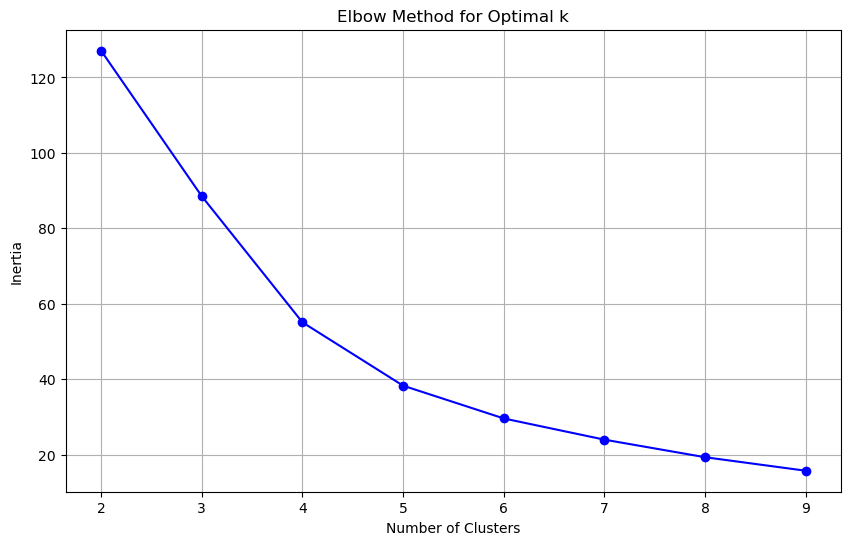


Employee Clusters Profile:
   cluster  employee_id  total_shifts  violations  violation_rate  \
0        0            1     25.000000    0.000000        0.000000   
1        1           12    649.583333  172.083333        0.316959   
2        2           32    538.500000   39.093750        0.085470   

                 department Supervisor  
0           QUALITY CONTROL     Ashley  
1  RESEARCH AND DEVELOPMENT    Jessica  
2                 WAREHOUSE     Robert  


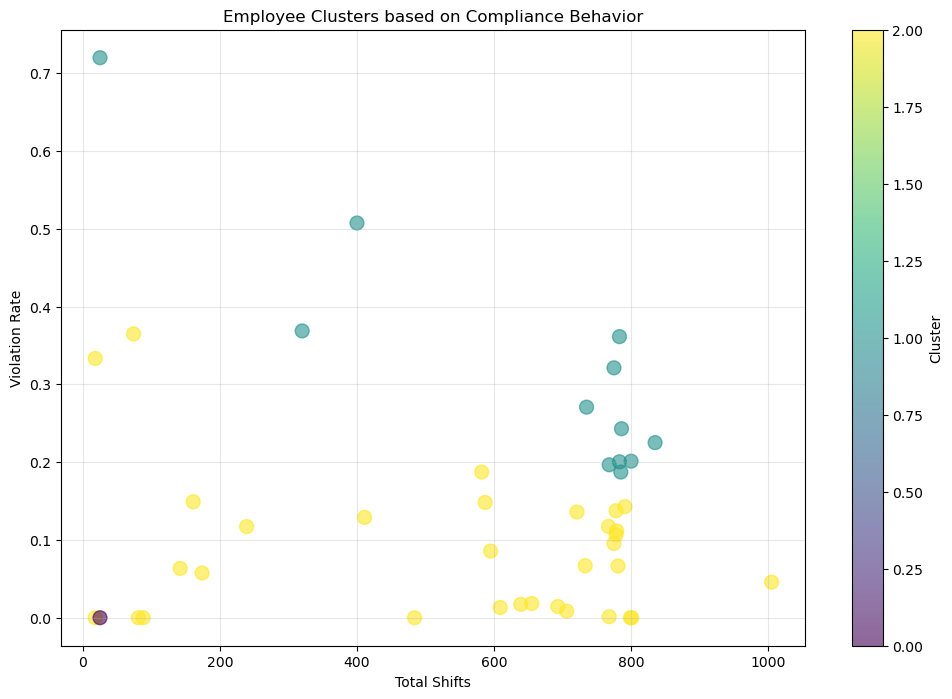


3. INTERVENTION EFFECTIVENESS ANALYSIS

Intervention Analysis (before/after 2023-01):
Average compliance before: 70.47%
Average compliance after: 96.07%
Change: 25.61% (improvement)
Statistical significance: p-value = 0.0000
The change is statistically significant


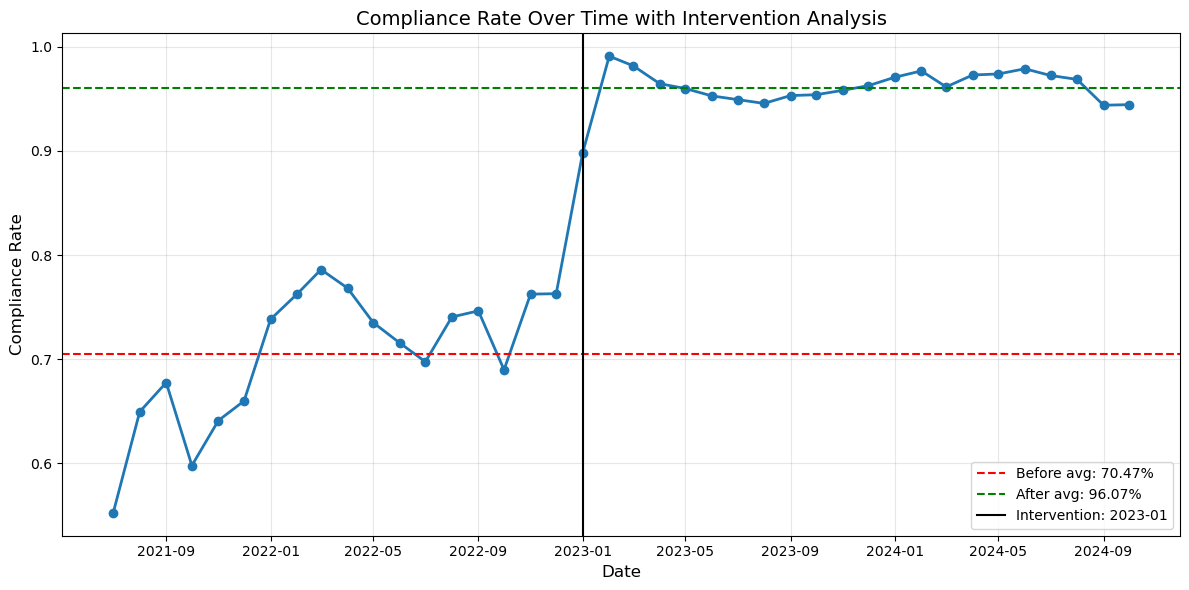


4. GENERATING ML-BASED RECOMMENDATIONS

Generating machine learning insights...
Starting prediction model building...
Data preview:
   total_work_hours   department   Supervisor  day_of_week  is_compliant
0          8.000000  PROCUREMENT  Christopher            0          True
1          8.000000  PROCUREMENT  Christopher            1          True
2          8.000000  PROCUREMENT  Christopher            2          True
3          4.616667  PROCUREMENT  Christopher            3          True
4          8.050000  PROCUREMENT  Christopher            4          True
Missing values: total_work_hours    0
department          0
Supervisor          0
day_of_week         0
is_compliant        0
dtype: int64
Processed features shape: (25052, 41)
Sample of processed features:
   total_work_hours  day_of_week  department_ADMINISTRATION  \
0          8.000000            0                      False   
1          8.000000            1                      False   
2          8.000000            2 

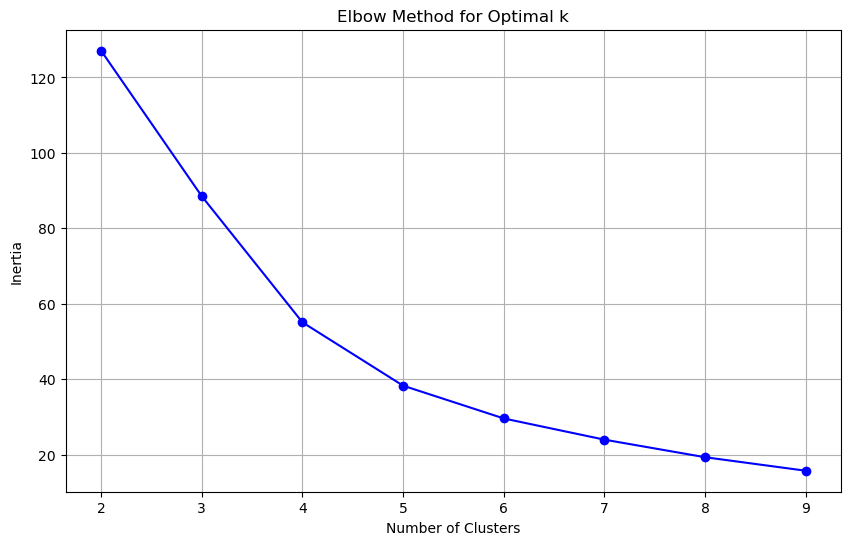


Employee Clusters Profile:
   cluster  employee_id  total_shifts  violations  violation_rate  \
0        0            1     25.000000    0.000000        0.000000   
1        1           12    649.583333  172.083333        0.316959   
2        2           32    538.500000   39.093750        0.085470   

                 department Supervisor  
0           QUALITY CONTROL     Ashley  
1  RESEARCH AND DEVELOPMENT    Jessica  
2                 WAREHOUSE     Robert  


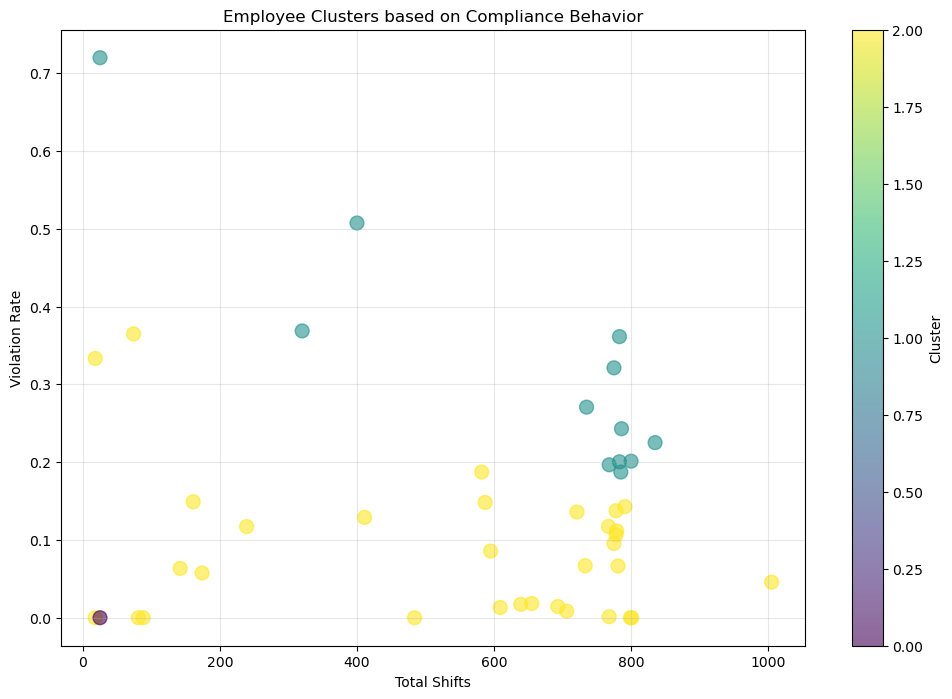


Intervention Analysis (before/after 2023-01):
Average compliance before: 70.47%
Average compliance after: 96.07%
Change: 25.61% (improvement)
Statistical significance: p-value = 0.0000
The change is statistically significant


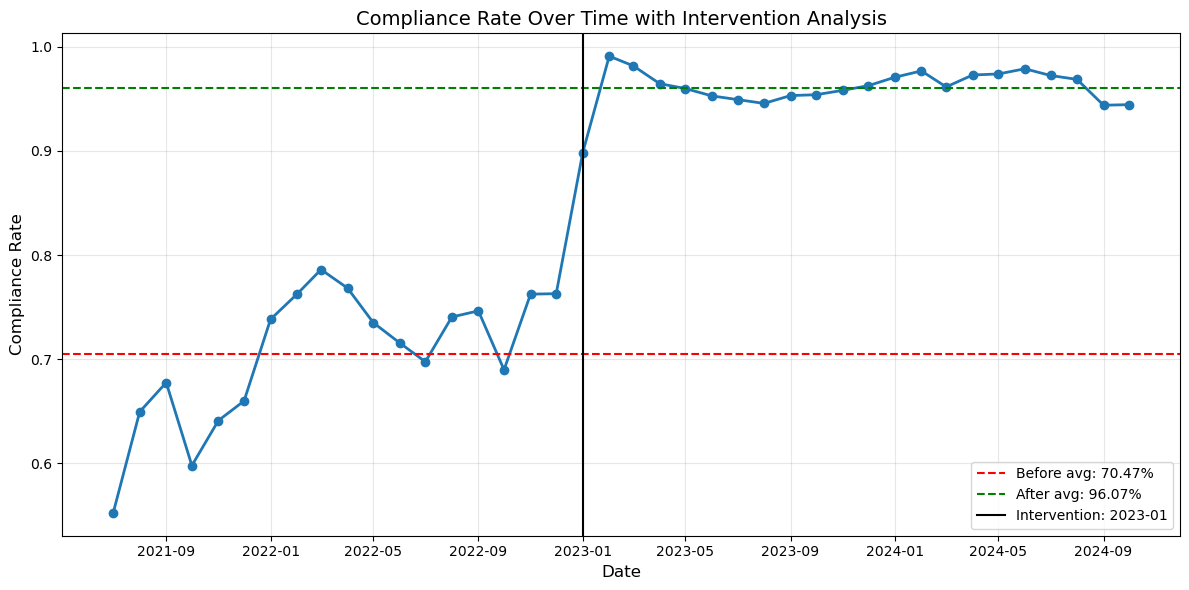


--- ML-ENHANCED ANALYSIS SUMMARY ---

KEY MACHINE LEARNING INSIGHTS:

Prediction Based:
1. Focus on key factors that predict violations: total_work_hours, day_of_week, Supervisor_Susan, Supervisor_Elizabeth, Supervisor_Patricia
2. Implement targeted supervisor training based on ML model results
3. Consider adjusting shift lengths to reduce compliance risk
4. Implement enhanced monitoring on high-risk days of the week

Clustering Based:
1. Focus on employee cluster 1 with highest violation rate (31.70%)
2. Target department 'RESEARCH AND DEVELOPMENT' which has highest concentration of compliance issues
3. Provide additional training to supervisor 'Jessica' who manages high-risk employees
4. Provide targeted coaching to high-risk employees: 697, 8920, 7804, 7195, 9274

Intervention Based:
1. Continue and expand current compliance initiatives which showed significant improvement of 25.61%


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os

class MealBreakComplianceAnalyzer:
    """
    A class to analyze meal break compliance according to California's Section 512(a).
    This analyzes Company XYZ's adherence to meal break laws and provides recommendations.
    """
    
    def __init__(self, timekeeping_file, payroll_file):
        """
        Initialize the analyzer with the timekeeping and payroll data files.
        
        Args:
            timekeeping_file (str): Path to the timekeeping Excel file
            payroll_file (str): Path to the payroll Excel file
        """
        print(f"Loading data from {timekeeping_file} and {payroll_file}...")
        self.timekeeping_df = pd.read_excel(timekeeping_file)
        self.payroll_df = pd.read_excel(payroll_file)
        
        # Pre-process data
        self._preprocess_data()
    
    def _preprocess_data(self):
        """Preprocess the timekeeping and payroll data."""
        # Convert datetime columns to datetime type if they aren't already
        datetime_cols = ['punchin1', 'punchout1', 'punchin2', 'punchout2', 'punchin3', 'punchout3']
        for col in datetime_cols:
            if col in self.timekeeping_df.columns:
                self.timekeeping_df[col] = pd.to_datetime(self.timekeeping_df[col], errors='coerce')
        
        # Convert date column to datetime if it's not already
        if 'date' in self.timekeeping_df.columns:
            self.timekeeping_df['date'] = pd.to_datetime(self.timekeeping_df['date'], errors='coerce')
        
        # Convert employee_id to string to ensure consistent joining
        self.timekeeping_df['employee_id'] = self.timekeeping_df['employee_id'].astype(str)
        self.payroll_df['employee_id'] = self.payroll_df['employee_id'].astype(str)
        
        # Create additional date features for analysis
        self.timekeeping_df['year_month'] = self.timekeeping_df['date'].dt.strftime('%Y-%m')
        self.timekeeping_df['day_of_week'] = self.timekeeping_df['date'].dt.dayofweek
        self.timekeeping_df['day_name'] = self.timekeeping_df['date'].dt.day_name()
        
        # Handle any missing pay rates in payroll data
        self.payroll_df['pay_rate'] = pd.to_numeric(self.payroll_df['pay_rate'], errors='coerce')
        
        print(f"Preprocessing complete. Timekeeping records: {len(self.timekeeping_df)}, Payroll records: {len(self.payroll_df)}")
        
    def _calculate_hours_between(self, start_time, end_time):
        """
        Calculate hours between two datetime values.
        
        Args:
            start_time: Start datetime
            end_time: End datetime
            
        Returns:
            float: Hours between start and end (0 if either is None)
        """
        if pd.isna(start_time) or pd.isna(end_time):
            return 0
        
        return (end_time - start_time).total_seconds() / 3600
        
    def analyze_compliance(self):
        """
        Analyze meal break compliance for each shift.
        
        Returns:
            DataFrame: Timekeeping data with compliance analysis columns added
        """
        print("Analyzing meal break compliance...")
        # Create a copy of the dataframe to avoid modifying the original
        df = self.timekeeping_df.copy()
        
        # Calculate work periods and meal breaks
        df['work_period1_hours'] = df.apply(lambda row: self._calculate_hours_between(row['punchin1'], row['punchout1']), axis=1)
        df['work_period2_hours'] = df.apply(lambda row: self._calculate_hours_between(row['punchin2'], row['punchout2']), axis=1)
        df['meal_break1_hours'] = df.apply(lambda row: self._calculate_hours_between(row['punchout1'], row['punchin2']), axis=1)
        
        # Handle optional third work period and second meal break
        df['work_period3_hours'] = df.apply(lambda row: self._calculate_hours_between(row['punchin3'], row['punchout3']), axis=1)
        df['meal_break2_hours'] = df.apply(lambda row: self._calculate_hours_between(row['punchout2'], row['punchin3']), axis=1)
        
        # Calculate total work hours for each shift
        df['total_work_hours'] = df['work_period1_hours'] + df['work_period2_hours'] + df['work_period3_hours']
        
        # Analyze first meal break compliance (5-hour rule)
        df['first_meal_required'] = df['total_work_hours'] > 5
        df['first_meal_taken'] = df['meal_break1_hours'] >= 0.5
        df['first_meal_compliant'] = ~(
            (df['total_work_hours'] > 5) & 
            (df['meal_break1_hours'] < 0.5) & 
            (df['total_work_hours'] > 6)
        )
        
        # Analyze second meal break compliance (10-hour rule)
        df['second_meal_required'] = df['total_work_hours'] > 10
        df['second_meal_taken'] = df['meal_break2_hours'] >= 0.5
        df['second_meal_compliant'] = ~(
            (df['total_work_hours'] > 10) & 
            (df['meal_break2_hours'] < 0.5) & 
            ((df['total_work_hours'] > 12) | (df['meal_break1_hours'] < 0.5))
        )
        
        # Determine overall compliance
        df['is_compliant'] = df['first_meal_compliant'] & df['second_meal_compliant']
        
        # Set violation reason if not compliant
        df['violation_reason'] = ''
        df.loc[~df['first_meal_compliant'], 'violation_reason'] = 'Missing first meal break'
        df.loc[~df['second_meal_compliant'], 'violation_reason'] = 'Missing second meal break'
        
        self.analyzed_df = df
        print(f"Compliance analysis complete. Found {(~df['is_compliant']).sum()} violations out of {len(df)} shifts.")
        return df
    
    def calculate_financial_impact(self, impute_missing=True):
        """
        Calculate the financial impact of meal break violations.
        
        Args:
            impute_missing (bool): Whether to impute missing pay rates
            
        Returns:
            tuple: (total_penalty, average_penalty_per_violation, violations_count, missing_rate_count)
        """
        if not hasattr(self, 'analyzed_df'):
            self.analyze_compliance()
            
        # Merge with payroll data to get pay rates
        merged_df = self.analyzed_df.merge(
            self.payroll_df[['employee_id', 'pay_rate']], 
            on='employee_id', 
            how='left'
        )
        
        # Handle missing pay rates if requested
        missing_rate_count = merged_df['pay_rate'].isna().sum()
        
        if impute_missing and missing_rate_count > 0:
            print(f"Imputing {missing_rate_count} missing pay rates...")
            # Get average pay rate by department
            dept_avg_rates = merged_df.groupby('department')['pay_rate'].mean()
            
            # Fill missing values with department average, or overall average if department has no rates
            overall_avg = merged_df['pay_rate'].mean()
            
            for dept in merged_df['department'].unique():
                dept_mask = (merged_df['department'] == dept) & (merged_df['pay_rate'].isna())
                if dept in dept_avg_rates and not pd.isna(dept_avg_rates[dept]):
                    merged_df.loc[dept_mask, 'pay_rate'] = dept_avg_rates[dept]
                else:
                    merged_df.loc[dept_mask, 'pay_rate'] = overall_avg
            
            # Any remaining NaN values get the overall average
            merged_df['pay_rate'].fillna(overall_avg, inplace=True)
        
        # Calculate penalties (one hour of pay per violation)
        violations = merged_df[~merged_df['is_compliant']]
        total_penalty = violations['pay_rate'].sum()
        violations_count = len(violations)
        avg_penalty = total_penalty / violations_count if violations_count > 0 else 0
        
        print(f"Financial impact calculated: ${total_penalty:.2f} total penalties, ${avg_penalty:.2f} avg per violation")
        return total_penalty, avg_penalty, violations_count, missing_rate_count
    
    def analyze_by_department(self):
        """
        Analyze compliance rates by department.
        
        Returns:
            DataFrame: Compliance statistics by department
        """
        if not hasattr(self, 'analyzed_df'):
            self.analyze_compliance()
            
        dept_stats = self.analyzed_df.groupby('department').agg(
            total_shifts=('employee_id', 'count'),
            violations=('is_compliant', lambda x: (~x).sum()),
            avg_shift_length=('total_work_hours', 'mean')
        ).reset_index()
        
        dept_stats['compliance_rate'] = (dept_stats['total_shifts'] - dept_stats['violations']) / dept_stats['total_shifts']
        dept_stats = dept_stats.sort_values('compliance_rate')
        
        return dept_stats
    
    def analyze_by_supervisor(self, min_shifts=100):
        """
        Analyze compliance rates by supervisor.
        
        Args:
            min_shifts (int): Minimum number of shifts for a supervisor to be included
            
        Returns:
            DataFrame: Compliance statistics by supervisor
        """
        if not hasattr(self, 'analyzed_df'):
            self.analyze_compliance()
            
        # Group by supervisor
        sup_counts = self.analyzed_df.groupby('Supervisor').size()
        valid_supervisors = sup_counts[sup_counts >= min_shifts].index
        
        filtered_df = self.analyzed_df[self.analyzed_df['Supervisor'].isin(valid_supervisors)]
        
        sup_stats = filtered_df.groupby('Supervisor').agg(
            total_shifts=('employee_id', 'count'),
            violations=('is_compliant', lambda x: (~x).sum()),
            avg_shift_length=('total_work_hours', 'mean')
        ).reset_index()
        
        sup_stats['compliance_rate'] = (sup_stats['total_shifts'] - sup_stats['violations']) / sup_stats['total_shifts']
        sup_stats = sup_stats.sort_values('compliance_rate')
        
        return sup_stats
    
    def analyze_by_employee(self, min_shifts=30):
        """
        Analyze compliance rates by employee.
        
        Args:
            min_shifts (int): Minimum number of shifts for an employee to be included
            
        Returns:
            DataFrame: Compliance statistics by employee
        """
        if not hasattr(self, 'analyzed_df'):
            self.analyze_compliance()
            
        # Group by employee
        emp_counts = self.analyzed_df.groupby('employee_id').size()
        valid_employees = emp_counts[emp_counts >= min_shifts].index
        
        filtered_df = self.analyzed_df[self.analyzed_df['employee_id'].isin(valid_employees)]
        
        # Get department and supervisor for each employee (using mode)
        emp_dept = filtered_df.groupby('employee_id')['department'].agg(lambda x: x.mode()[0]).reset_index()
        emp_sup = filtered_df.groupby('employee_id')['Supervisor'].agg(lambda x: x.mode()[0] if len(x.mode()) > 0 else "Unknown").reset_index()
        
        emp_stats = filtered_df.groupby('employee_id').agg(
            total_shifts=('date', 'count'),
            violations=('is_compliant', lambda x: (~x).sum()),
            avg_shift_length=('total_work_hours', 'mean')
        ).reset_index()
        
        # Merge with department and supervisor info
        emp_stats = emp_stats.merge(emp_dept, on='employee_id', how='left')
        emp_stats = emp_stats.merge(emp_sup, on='employee_id', how='left')
        
        emp_stats['violation_rate'] = emp_stats['violations'] / emp_stats['total_shifts']
        emp_stats = emp_stats.sort_values('violations', ascending=False)
        
        return emp_stats
    
    def analyze_monthly_trends(self):
        """
        Analyze compliance trends by month.
        
        Returns:
            DataFrame: Monthly compliance statistics
        """
        if not hasattr(self, 'analyzed_df'):
            self.analyze_compliance()
            
        monthly_stats = self.analyzed_df.groupby('year_month').agg(
            total_shifts=('employee_id', 'count'),
            violations=('is_compliant', lambda x: (~x).sum())
        ).reset_index()
        
        monthly_stats['compliance_rate'] = (monthly_stats['total_shifts'] - monthly_stats['violations']) / monthly_stats['total_shifts']
        monthly_stats = monthly_stats.sort_values('year_month')
        
        return monthly_stats

    # ===================== MACHINE LEARNING METHODS =====================

    def build_compliance_prediction_model(self):
        """Build a machine learning model to predict compliance violations."""
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import classification_report
        
        print("Starting prediction model building...")
        
        try:
            # Feature engineering
            features_df = self.analyzed_df.copy()
            
            print("Data preview:")
            print(features_df[['total_work_hours', 'department', 'Supervisor', 'day_of_week', 'is_compliant']].head())
            print(f"Missing values: {features_df[['total_work_hours', 'department', 'Supervisor', 'day_of_week', 'is_compliant']].isnull().sum()}")
            
            # Create features (example features - you can add more)
            features = ['total_work_hours', 'department', 'Supervisor', 'day_of_week']
            
            # Handle categorical features
            features_processed = pd.get_dummies(features_df[features], columns=['department', 'Supervisor'])
            
            # Check for problems with data
            print(f"Processed features shape: {features_processed.shape}")
            print(f"Sample of processed features:\n{features_processed.head()}")
            
            # Target variable
            y = ~features_df['is_compliant'].astype(bool)  # Ensuring it's boolean
            print(f"Target variable distribution:\n{y.value_counts()}")
            
            # Split data
            X_train, X_test, y_train, y_test = train_test_split(
                features_processed, y, test_size=0.25, random_state=42
            )
            
            print(f"Training data shape: {X_train.shape}, {y_train.shape}")
            print(f"Testing data shape: {X_test.shape}, {y_test.shape}")
            
            # Train model
            print("Training model...")
            model = RandomForestClassifier(n_estimators=100, random_state=42)
            model.fit(X_train, y_train)
            
            # Evaluate
            y_pred = model.predict(X_test)
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred))
            
            # Feature importance
            feature_importance = pd.DataFrame({
                'feature': features_processed.columns,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("\nMost important factors for compliance violations:")
            print(feature_importance.head(10))
            
            return model, feature_importance
            
        except Exception as e:
            print(f"Error in building prediction model: {e}")
            import traceback
            traceback.print_exc()
            return None, None
    
    def identify_compliance_clusters(self):
        """Use clustering to identify natural groupings in compliance data."""
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        
        print("Starting clustering analysis...")
        
        try:
            # Prepare employee-level data
            emp_data = self.analyze_by_employee(min_shifts=10)
            
            # Make sure we have enough data
            if len(emp_data) < 10:
                print("Not enough employee data for meaningful clustering")
                return None, None
            
            # Select features for clustering
            features = ['total_shifts', 'violations', 'avg_shift_length', 'violation_rate']
            X = emp_data[features].copy()
            
            # Check for any missing values
            if X.isnull().any().any():
                print("Handling missing values in clustering data...")
                X = X.fillna(X.mean())
            
            # Scale the data
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X)
            
            # Find optimal number of clusters using the elbow method
            inertia = []
            k_range = range(2, min(10, len(emp_data)-1))
            for k in k_range:
                kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
                kmeans.fit(X_scaled)
                inertia.append(kmeans.inertia_)
            
            # Plot elbow curve
            plt.figure(figsize=(10, 6))
            plt.plot(k_range, inertia, 'bo-')
            plt.title('Elbow Method for Optimal k')
            plt.xlabel('Number of Clusters')
            plt.ylabel('Inertia')
            plt.grid(True)
            plt.show()
            
            # Choose number of clusters (simplified for automation)
            optimal_k = 3  # Default value, can be adjusted based on elbow curve
            
            # Run KMeans with optimal k
            kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(X_scaled)
            emp_data['cluster'] = cluster_labels
            
            # Analyze the clusters
            cluster_profiles = emp_data.groupby('cluster').agg({
                'employee_id': 'count',
                'total_shifts': 'mean',
                'violations': 'mean',
                'violation_rate': 'mean',
                'department': lambda x: x.value_counts().index[0],  # most common department
                'Supervisor': lambda x: x.value_counts().index[0]   # most common supervisor
            }).reset_index()
            
            print("\nEmployee Clusters Profile:")
            print(cluster_profiles)
            
            # Visualize clusters
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(
                emp_data['total_shifts'], 
                emp_data['violation_rate'],
                c=emp_data['cluster'], 
                cmap='viridis', 
                s=100, 
                alpha=0.6
            )
            plt.colorbar(scatter, label='Cluster')
            plt.xlabel('Total Shifts')
            plt.ylabel('Violation Rate')
            plt.title('Employee Clusters based on Compliance Behavior')
            plt.grid(True, alpha=0.3)
            plt.show()
            
            return emp_data, cluster_profiles
            
        except Exception as e:
            print(f"Error in clustering analysis: {e}")
            import traceback
            traceback.print_exc()
            return None, None
    
    def analyze_intervention_effectiveness(self, intervention_date='2023-01'):
        """Analyze the effectiveness of compliance initiatives."""
        try:
            # Get monthly data
            monthly_data = self.analyze_monthly_trends()
            
            # Check if we have enough data before and after intervention
            before_intervention = monthly_data[monthly_data['year_month'] < intervention_date]
            after_intervention = monthly_data[monthly_data['year_month'] >= intervention_date]
            
            if len(before_intervention) < 2 or len(after_intervention) < 2:
                print("Not enough data to analyze intervention effectiveness")
                return None
            
            # Convert to datetime for proper plotting
            monthly_data['date'] = pd.to_datetime(monthly_data['year_month'] + '-01')
            
            # Calculate average compliance rates before and after
            before_avg = before_intervention['compliance_rate'].mean()
            after_avg = after_intervention['compliance_rate'].mean()
            change = after_avg - before_avg
            
            print(f"\nIntervention Analysis (before/after {intervention_date}):")
            print(f"Average compliance before: {before_avg:.2%}")
            print(f"Average compliance after: {after_avg:.2%}")
            print(f"Change: {change:.2%} ({'improvement' if change > 0 else 'decline'})")
            
            # Statistical significance (simple t-test)
            from scipy import stats
            t_stat, p_value = stats.ttest_ind(
                before_intervention['compliance_rate'],
                after_intervention['compliance_rate'],
                equal_var=False
            )
            
            print(f"Statistical significance: p-value = {p_value:.4f}")
            print(f"The change is {'statistically significant' if p_value < 0.05 else 'not statistically significant'}")
            
            # Visualize the change
            plt.figure(figsize=(12, 6))
            plt.plot(monthly_data['date'], monthly_data['compliance_rate'], 'o-', linewidth=2)
            
            # Add horizontal lines for averages
            plt.axhline(y=before_avg, color='r', linestyle='--', 
                        label=f'Before avg: {before_avg:.2%}')
            plt.axhline(y=after_avg, color='g', linestyle='--',
                        label=f'After avg: {after_avg:.2%}')
            
            # Add vertical line for intervention
            intervention_date_dt = pd.to_datetime(intervention_date + '-01')
            plt.axvline(x=intervention_date_dt, color='k', linestyle='-',
                        label=f'Intervention: {intervention_date}')
            
            plt.title('Compliance Rate Over Time with Intervention Analysis', fontsize=14)
            plt.xlabel('Date', fontsize=12)
            plt.ylabel('Compliance Rate', fontsize=12)
            plt.grid(True, alpha=0.3)
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            return {
                'before_avg': before_avg,
                'after_avg': after_avg,
                'change': change,
                'p_value': p_value,
                'significant': p_value < 0.05
            }
            
        except Exception as e:
            print(f"Error in intervention analysis: {e}")
            import traceback
            traceback.print_exc()
            return None
    
    def generate_ml_recommendations(self):
        """Generate machine learning based recommendations."""
        recommendations = {
            'prediction_based': [],
            'clustering_based': [],
            'intervention_based': []
        }
        
        # Get prediction model insights
        print("\nGenerating machine learning insights...")
        model, importance = self.build_compliance_prediction_model()
        
        if model is not None and importance is not None:
            # Get top factors
            top_factors = importance.head(5)['feature'].tolist()
            recommendations['prediction_based'].append(
                f"Focus on key factors that predict violations: {', '.join(top_factors)}"
            )
            
            # Employee targeting
            if 'Supervisor' in ''.join(top_factors):
                recommendations['prediction_based'].append(
                    "Implement targeted supervisor training based on ML model results"
                )
            
            if 'department' in ''.join(top_factors):
                recommendations['prediction_based'].append(
                    "Develop department-specific compliance protocols based on ML insights"
                )
            
            if 'total_work_hours' in top_factors:
                recommendations['prediction_based'].append(
                    "Consider adjusting shift lengths to reduce compliance risk"
                )
                
            if 'day_of_week' in top_factors:
                recommendations['prediction_based'].append(
                    "Implement enhanced monitoring on high-risk days of the week"
                )
        
        # Get clustering insights
        clusters, cluster_profiles = self.identify_compliance_clusters()
        
        if clusters is not None and cluster_profiles is not None:
            # Identify problematic cluster
            problem_cluster = cluster_profiles.loc[cluster_profiles['violation_rate'].idxmax()]
            
            recommendations['clustering_based'].append(
                f"Focus on employee cluster {problem_cluster['cluster']} with highest violation rate ({problem_cluster['violation_rate']:.2%})"
            )
            
            if 'department' in problem_cluster:
                recommendations['clustering_based'].append(
                    f"Target department '{problem_cluster['department']}' which has highest concentration of compliance issues"
                )
            
            if 'Supervisor' in problem_cluster:
                recommendations['clustering_based'].append(
                    f"Provide additional training to supervisor '{problem_cluster['Supervisor']}' who manages high-risk employees"
                )
            
            # Get specific employees to target
            high_risk_employees = clusters[clusters['cluster'] == problem_cluster['cluster']].sort_values('violations', ascending=False).head(5)
            if not high_risk_employees.empty:
                emp_ids = high_risk_employees['employee_id'].tolist()
                recommendations['clustering_based'].append(
                    f"Provide targeted coaching to high-risk employees: {', '.join(map(str, emp_ids))}"
                )
        
        # Get intervention effectiveness insights
        intervention_results = self.analyze_intervention_effectiveness()
        
        if intervention_results is not None:
            if intervention_results['change'] > 0:
                if intervention_results['significant']:
                    recommendations['intervention_based'].append(
                        f"Continue and expand current compliance initiatives which showed significant improvement of {intervention_results['change']:.2%}"
                    )
                else:
                    recommendations['intervention_based'].append(
                        f"Current initiatives show positive but non-significant improvement of {intervention_results['change']:.2%}. Consider strengthening approach."
                    )
            else:
                recommendations['intervention_based'].append(
                    f"Current compliance initiatives are not effective. Consider complete redesign of approach."
                )
        
        return recommendations

# Example usage with all ML features
def run_ml_enhanced_analysis(timekeeping_file, payroll_file, output_dir=None):
    """Run complete analysis with machine learning enhancements."""
    # Create output directory if needed
    if output_dir and not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Initialize analyzer and run basic analysis
    analyzer = MealBreakComplianceAnalyzer(timekeeping_file, payroll_file)
    analyzer.analyze_compliance()
    analyzer.calculate_financial_impact()
    
    # Get basic analysis results
    dept_stats = analyzer.analyze_by_department()
    monthly_stats = analyzer.analyze_monthly_trends()
    
    print("\n--- BASIC ANALYSIS COMPLETE ---")
    print(f"Total Violations: {(~analyzer.analyzed_df['is_compliant']).sum()}")
    print(f"Compliance Rate: {analyzer.analyzed_df['is_compliant'].mean():.2%}")
    
    # Run ML analysis
    print("\n--- STARTING MACHINE LEARNING ANALYSIS ---")
    
    # Predictive modeling
    print("\n1. PREDICTIVE MODELING")
    model, importance = analyzer.build_compliance_prediction_model()
    
    # Clustering analysis
    print("\n2. CLUSTERING ANALYSIS")
    clusters, cluster_profiles = analyzer.identify_compliance_clusters()
    
    # Intervention effectiveness
    print("\n3. INTERVENTION EFFECTIVENESS ANALYSIS")
    intervention_results = analyzer.analyze_intervention_effectiveness()
    
    # Generate ML recommendations
    print("\n4. GENERATING ML-BASED RECOMMENDATIONS")
    ml_recommendations = analyzer.generate_ml_recommendations()
    
    # Print final summary with ML insights
    print("\n--- ML-ENHANCED ANALYSIS SUMMARY ---")
    print("\nKEY MACHINE LEARNING INSIGHTS:")
    
    for category, recs in ml_recommendations.items():
        print(f"\n{category.replace('_', ' ').title()}:")
        for i, rec in enumerate(recs):
            print(f"{i+1}. {rec}")
    
    return analyzer

if __name__ == "__main__":
    # File paths
    timekeeping_file = "Timekeeping.xlsx"
    payroll_file = "Payroll.xlsx"
    output_dir = "analysis_results"
    
    # Run analysis with ML features
    analyzer = run_ml_enhanced_analysis(timekeeping_file, payroll_file, output_dir)